In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import string

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from wordcloud import WordCloud

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE

import tensorflow
import keras
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint

import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

# Observations

In [2]:
# Load Data, Initialize Dataframe
imdb_reviews_df = pd.read_csv('imdb_reviews.csv')

In [3]:
imdb_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [4]:
imdb_reviews_df.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


In [5]:
# Add new Column with Descriptive Value of Label
label_dict = {0:'Negative', 1:'Positive'}
imdb_reviews_df['emotion'] = imdb_reviews_df['label'].map(label_dict)

In [6]:
# Drop old label columns
imdb_reviews_df.drop('label', axis=1, inplace=True)

In [7]:
imdb_reviews_df.head(10)

,text,emotion
0,I grew up (b. 1965) watching and loving the Th...,Negative
1,"When I put this movie in my DVD player, and sa...",Negative
2,Why do people who do not know what a particula...,Negative
3,Even though I have great interest in Biblical ...,Negative
4,Im a die hard Dads Army fan and nothing will e...,Positive
5,A terrible movie as everyone has said. What ma...,Negative
6,Finally watched this shocking movie last night...,Positive
7,I caught this film on AZN on cable. It sounded...,Negative
8,It may be the remake of 1987 Autumn's Tale aft...,Positive
9,My Super Ex Girlfriend turned out to be a plea...,Positive


In [8]:
imdb_reviews_df['emotion'].value_counts()

Negative    20019
Positive    19981
Name: emotion, dtype: int64

# Text Processing

In order for the text from the movie reviews to be useful for Sentiment Analysis modeling and predictions, we need to clean it up by applying the following transformations:

1. Removal of special characters that could confuse the models and standardization of capitilization
2. Tokenization using RegexpTokenizer
3. Lemmatization of the Tokens
4. Removal of stopwords and modification of stopword library if needed

I will create a function that takes in the text as is from the dataset and returns a cleaned format

In [79]:
def text_cleaning(text):
    """
    Args:
        text(string): The text from which punctuation, stopwords are removed and lemmatized
        
    Returns:
        clean_text(string): A text formed after text preprocessing.
    """
    
    # Remove any urls from the text
    text = re.sub(r'https:\/\/.*[\r\n]*',
                  "",
                  str(text))
    
    # Remove any urls starting from www. in the text
    text = re.sub(r'www\.\w*\.\w\w\w',
                  "",
                  str(text))
    
    # Remove any html elements from the text
    text = re.sub(r"<[\w]*[\s]*/>",
                  "",
                  str(text))
    
    # Remove periods
    text = re.sub(r"[\.]*",
                  "",
                  str(text))
    
 
    # Initialize RegexpTokenizer
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)

    
    # Tokenize text
    text_tokens = tokenizer.tokenize(text.lower())
    
    lemmatizer  = WordNetLemmatizer()
    # Get english stopwords
    english_stopwords = stopwords.words("english")
    stopwords_to_add = ['movie', 'film', 'flick', 'story', 'thing', 'also', 'get', 'one','like']
    english_stopwords.extend(stopwords_to_add)
    cleaned_text_tokens = [] # A list to hold cleaned text tokens
    
    for word in text_tokens:
        if((word not in english_stopwords) and # Remove stopwords
            (word not in string.punctuation)): # Remove punctuation marks
                
                lemmas = lemmatizer.lemmatize(word) # Get lemma of the current word
                cleaned_text_tokens.append(lemmas) # Appened lemma word to list of cleaned list
    
    # Combine list into single string
    clean_text = " ".join(cleaned_text_tokens)
    
    return clean_text

In [80]:
imdb_reviews_df['clean_text'] = imdb_reviews_df['text'].apply(text_cleaning)

In [81]:
imdb_reviews_df[imdb_reviews_df['emotion']=='Negative']['clean_text']

0        grew b watching loving thunderbird mate school...
1        put dvd player sat coke chip expectation hopin...
2        people know particular time past feel need try...
3        even though great interest biblical movie bore...
5        terrible everyone said made laugh cameo appear...
                               ...                        
39984    relate failed engage either intellectually emo...
39985    comedy what's funny watching ugly deadbeat alc...
39993    best welsh trainspotting aye right went pretty...
39994    girlfriend habit going blockbuster choosing mo...
39997    wife watched plan visit sicily stromboli soon ...
Name: clean_text, Length: 20019, dtype: object

In [82]:
imdb_reviews_df.head(10)

,text,emotion,clean_text
0,I grew up (b. 1965) watching and loving the Th...,Negative,grew b watching loving thunderbird mate school...
1,"When I put this movie in my DVD player, and sa...",Negative,put dvd player sat coke chip expectation hopin...
2,Why do people who do not know what a particula...,Negative,people know particular time past feel need try...
3,Even though I have great interest in Biblical ...,Negative,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,Positive,im die hard dad army fan nothing ever change g...
5,A terrible movie as everyone has said. What ma...,Negative,terrible everyone said made laugh cameo appear...
6,Finally watched this shocking movie last night...,Positive,finally watched shocking last night disturbing...
7,I caught this film on AZN on cable. It sounded...,Negative,caught azn cable sounded would good japanese g...
8,It may be the remake of 1987 Autumn's Tale aft...,Positive,may remake autumn's tale eleven year director ...
9,My Super Ex Girlfriend turned out to be a plea...,Positive,super ex girlfriend turned pleasant surprise r...


### Word Distribution Analysis

In [83]:
dt_positive = imdb_reviews_df[imdb_reviews_df['emotion']=='Positive']['clean_text']

from collections import Counter
p = Counter(" ".join(dt_positive).split()).most_common(25)
positive_word_df = pd.DataFrame(p, columns=['Word', 'Frequency'])
print(positive_word_df)

         Word  Frequency
0        time      12678
1        good      11878
2   character      10951
3         see      10262
4       great      10248
5        well       9832
6        make       9067
7      really       8619
8       would       8387
9       scene       7881
10       life       7640
11       even       7623
12       show       7570
13       love       7349
14       much       7265
15      first       7250
16        way       6974
17     people       6854
18       best       6720
19       year       6076
20      think       6072
21       film       6050
22       many       5988
23       made       5758
24        two       5714


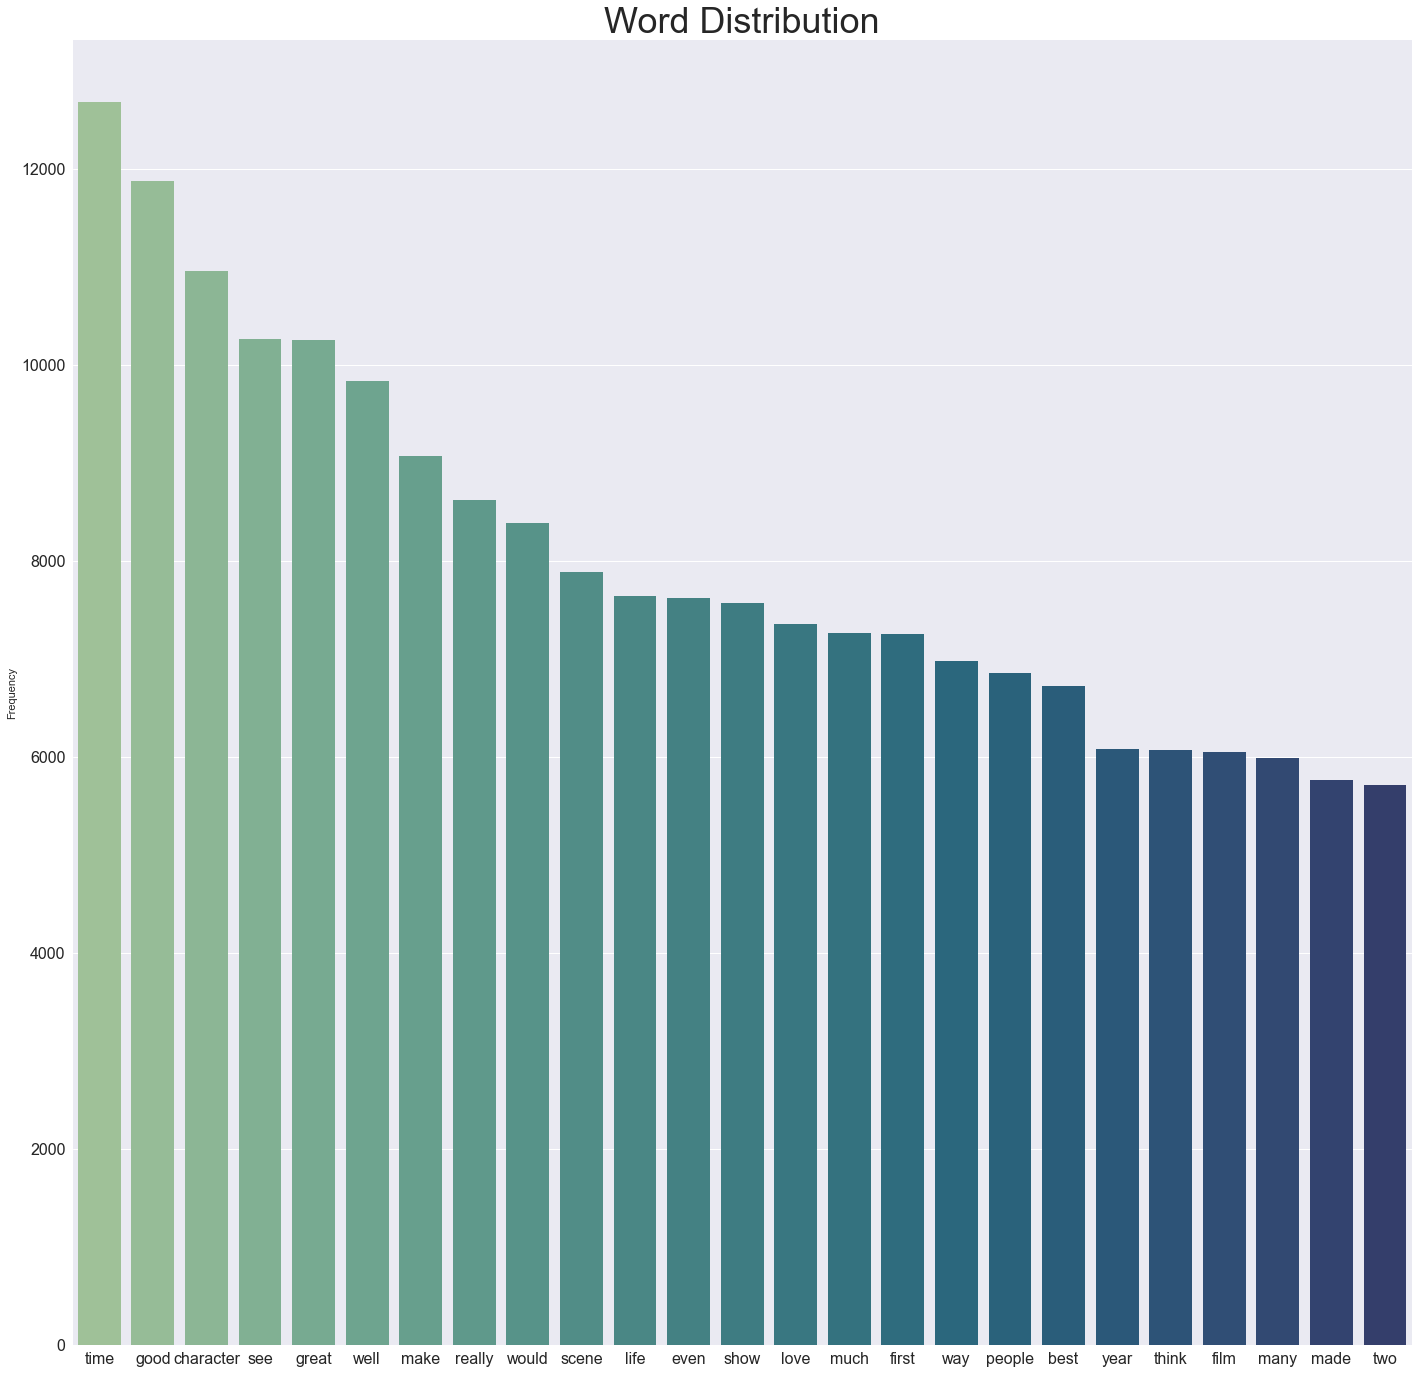

In [85]:
plt.figure(figsize=(24,24))
ax = sns.barplot(x='Word', y='Frequency', data = positive_word_df, palette='crest')
plt.title('Word Distribution', fontsize=36)
plt.xlabel('', )
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('./images/Positive_Word_Distribution_Barchart')

In [86]:
dt_negative = imdb_reviews_df[imdb_reviews_df['emotion']=='Negative']['clean_text']

from collections import Counter
p = Counter(" ".join(dt_negative).split()).most_common(25)
negative_word_df = pd.DataFrame(p, columns=['Word', 'Frequency'])
print(negative_word_df)

         Word  Frequency
0        even      12074
1        time      11834
2        good      11729
3         bad      11498
4   character      10989
5       would      10976
6        make      10343
7      really       9830
8       scene       8894
9         see       8783
10       much       7997
11     people       7404
12      could       7232
13       made       6914
14       plot       6688
15       well       6527
16        way       6497
17      movie       6490
18      first       6446
19     acting       6391
20         go       6115
21      think       6025
22       know       5993
23       look       5959
24       show       5923


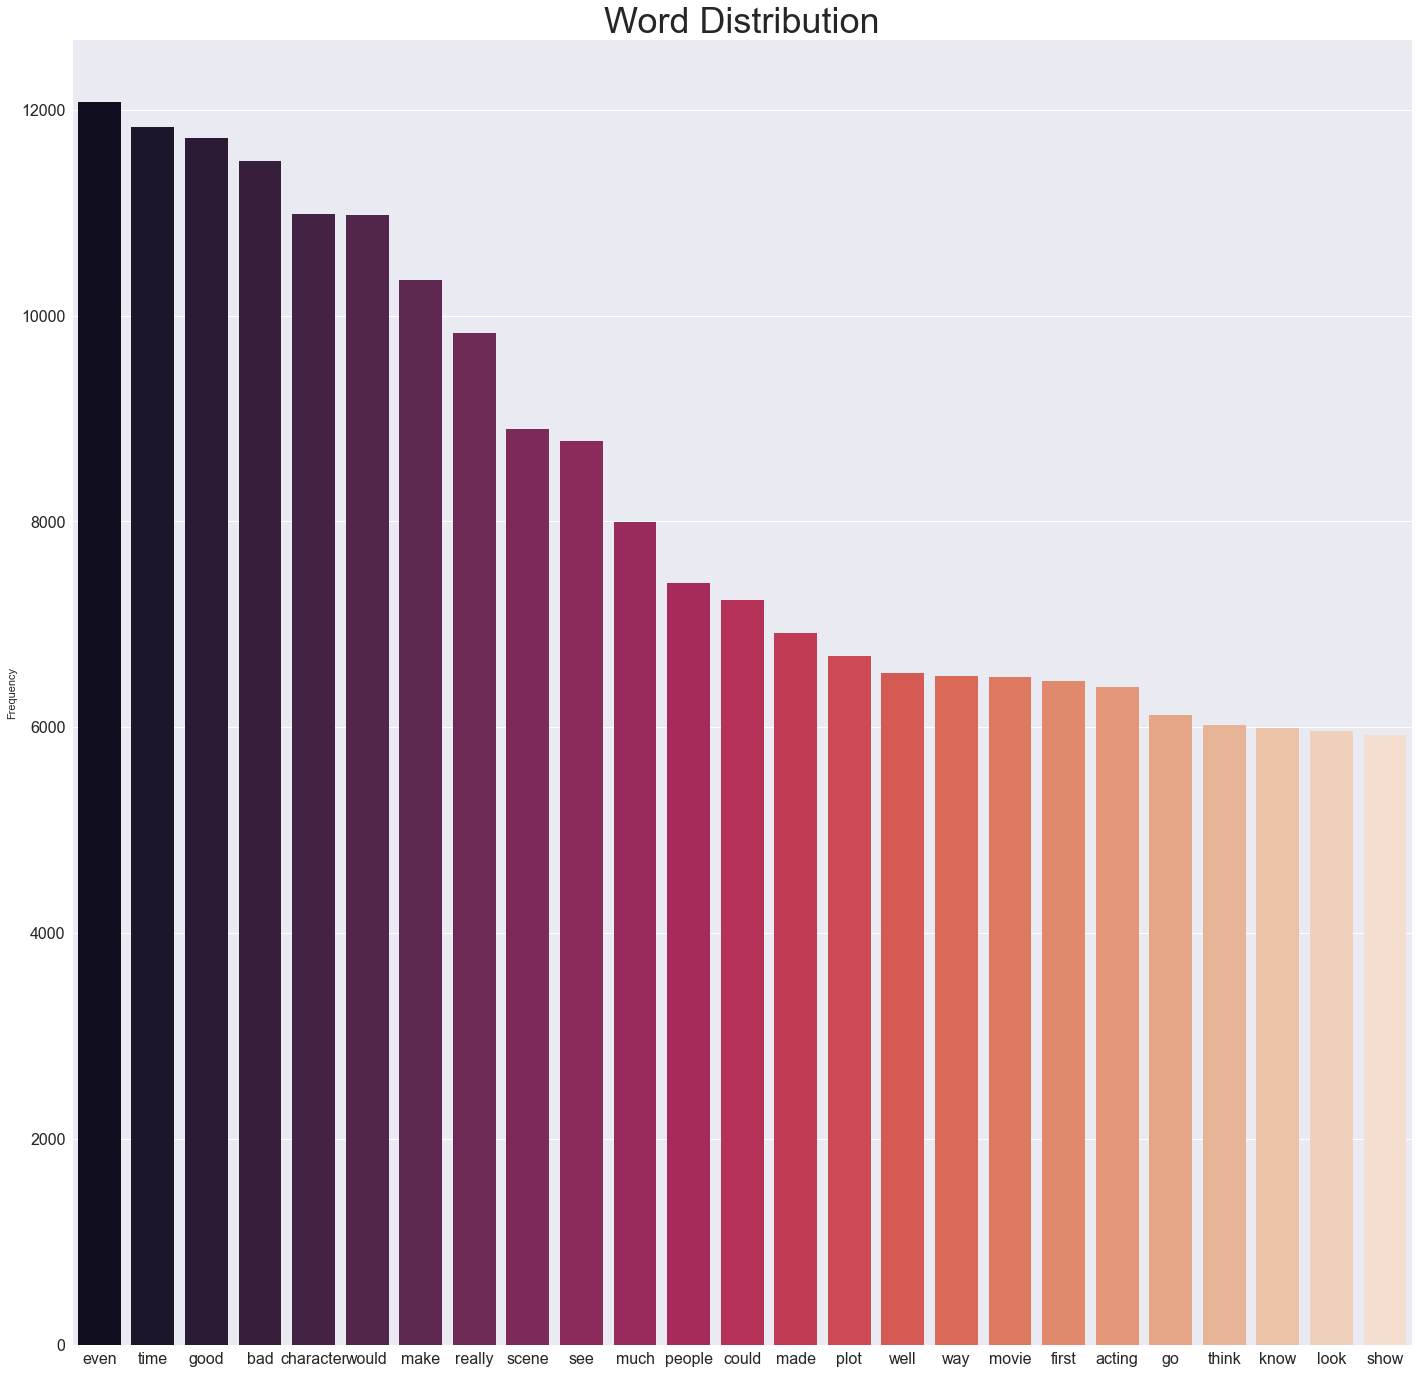

In [87]:
plt.figure(figsize=(24,24))
ax = sns.barplot(x='Word', y='Frequency', data = negative_word_df, palette='rocket')
plt.title('Word Distribution', fontsize=36)
plt.xlabel('', )
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('./images/Negative_Word_Distribution_Barchart')

### Train Test Split, TFIDF Vectorization

In [13]:
X = imdb_reviews_df.text
y = imdb_reviews_df.emotion

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 24)

In [14]:
tf_idf = TfidfVectorizer()

X_train = tf_idf.fit_transform(X_train.tolist())
X_test = tf_idf.transform(X_test.tolist())

In [15]:
print(X_train.shape, X_test.shape)

(24000, 97391) (16000, 97391)


In [18]:
# LabelEncode
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Baseline (Dummy) Model

In [ ]:
estimator = DummyClassifier(strategy='most_frequent')
estimator.fit(X_train, y_train)

# Get predictions with dummy model
y_pred = estimator.predict(X_test)

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Negative', 'Positive']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_Dummy');

target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))

### Logistic Regression

In [ ]:
pipe = ImPipeline(steps=[
    ('estimator', LogisticRegression(random_state=42))
    
])

param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f" Final Hyperparameters: {grid_search.best_params_}\n")
print(f" Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Negative', 'Positive']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)


target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/LogReg_Model');

#### Ridge Regression